# CIFAR-10 데이터에 Augmentation 기법을 활용
- Data augmentation : 기존 이미지에 변형을 주어 변형된 이미지를 이용해 모델 학습
  - 자르기, 회전하기, 반전하기 등 사람의 눈으로 확인했을 때 동일한 클래스로 분류할 수 있는 수준의 변형을 가해야 함
  

In [1]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.9.0+cu111  Device: cuda


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

- torchvision 모듈 내 transforms 함수를 활용, augmentation 수행
  - `transforms.Compose()` : 불러오는 이미지 데이터에 전처리 및 augmentation을 다양하게 적용할 때 이용하는 Method
    - `Compose`의 ()안에 있는 처리 과정을 거친 데이터를 불러오게 됨
  - `transforms.RandomHorizontalFlip()` : 해당 이미지를 50% 확률로 좌우 반전
  - `transforms.ToTensor()` : 0-1 정규화(Normalization) + Input을 Tensor 형태로 변환
  - `transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))` : 평균과 표준편차 활용한 표준화(Standardization)
    - input에서 앞 tuple이 RGB 각각 channel에 대한 평균, 뒤 tuple이 RGB 각각 channel에 대한 표준편차를 의미
  - 예시 : https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
  - doc : https://pytorch.org/vision/stable/transforms.html

In [4]:
''' 3. Data Augmentation이 적용된 CIFAR10 데이터 다운로드 (Train set, Test set 분리하기) '''
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                  train = True,
                                  download = True,
                                  transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(), 
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                train = False,
                                transform = transforms.Compose([
                                    # transforms.RandomHorizontalFlip(), # validation / test 데이터셋에서는 augmentation을 수행할 필요가 없음
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))


train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/CIFAR_10/cifar-10-python.tar.gz to ../data/CIFAR_10


In [5]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

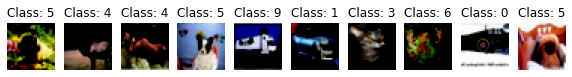

In [6]:
''' 5. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [7]:
''' 6. Convolutional Neural Network (CNN) 모델 설계하기 '''
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(8 * 8 * 16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(-1, 8 * 8 * 16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        # x = F.log_softmax(x)
        return x

In [8]:
''' 7. Optimizer, Objective Function 설정하기 '''
model = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [9]:
''' 8. CNN 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [10]:
''' 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [ ]:
''' 10. CNN 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.312783
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.707516
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 2.014791
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.598767
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.445360
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.448612
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.614795
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.507028

[EPOCH: 1], 	Test Loss: 0.0412, 	Test Accuracy: 52.80 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.313400
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.479651
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.287874
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.132298
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.195663
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.257015
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.006475
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.134928

[EPOCH: 2], 	Test Loss: 0.0367, 	Test Accuracy: 58.33 % 

KeyboardInterrupt: ignored